# 7.7. The Word Ladder Problem

The word ladder puzzle은

>FOOL
POOL
POLL
POLE
PALE
SALE
SAGE

이와 같이
어떠한 단어에서 한 번에 하나씩의 글자만 바꿔, 다른 단어로 교체해나가는 퍼즐입니다.

예컨대 FOOL에서 F를 P로 바꾸어 POOL, POOL에서 O를 바꿔 POLL로 바꾸어나가는 등의 퍼즐이라고 말할 수 있겠습니다. 

우리는 이 퍼즐을 통해서

* 단어들간의 관계를 그래프로 표현해낼 것이고
* bfs(breadth first search)라고 알려진 그래프 알고리즘을 사용하여 하나의 단어에서 마지막 단어까지 향하는 효율적인 경로를 찾아낼 것입니다.



# 7.8. Building the Word Ladder Graph

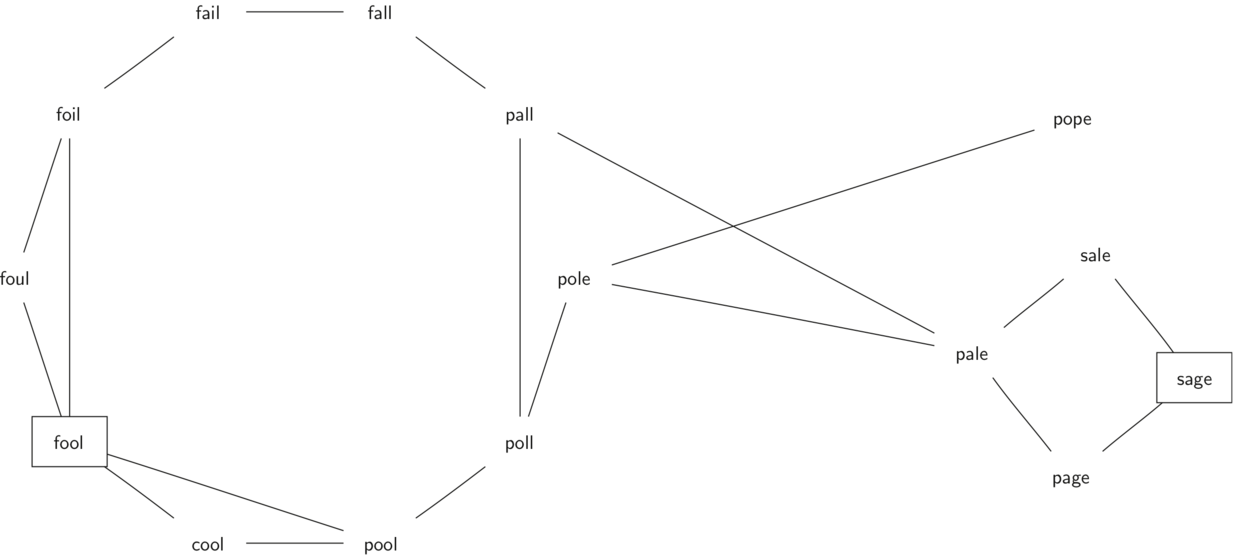









words들을 통해, 이러한 식으로 그래프를 만들 수 있을 겁니다.




그래프를 만드는 데에는 몇가지 방법이 있겠습니다.

우선 단어들이 모두 같은 길이를 가지고 있다고 가정해봅시다.


첫번째 방법은 모든 정점(vertex)을 하나하나 연결해보는 것입니다.
우리는 여러 단어들 중에서 딱 한 글자만 다른 단어들을 연결할 것인데 (POOL 이나 FOOL처럼요)

이 과정에서 어쨌든 모든 단어들간의 관계를 확인해봐야하기 때문에 
그래프를 형성하는데 O(n^2)의 실행시간이 걸리게 됩니다.


두번째 방법은 위의 알고리즘보다 더 좋습니다.


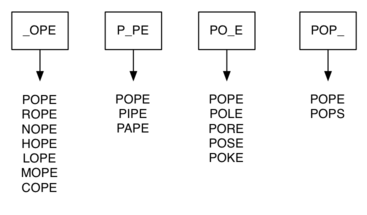



이러한 그림이 있다고 합시다.

우리는 엄청난 수의 버킷과 그 버킷에 주렁주렁 달린 단어들의 형태를 생각할 수 있습니다.
예컨대 첫번째 버킷에는 [\_OPE] 라는 라벨이 달려 있습니다.
우리는 여기에 두번째, 세번째, 네번째 문자가 각각 O,P,E 인 단어들을 모두 주렁주렁 연결할 겁니다.
\_가 와일드 카드로 작용하는 셈이죠.
두번째 버킷도, 세번째 버킷도 마찬가지이며, 각각의 단어들은 서로 다른 버킷에 중복해서 저장될 수 있다고 합시다.

파이썬에서는 이를 사전으로 구현할 수 있을겁니다.
키 값으로는 양동이(버킷)의 라벨, 밸류 값으로는 양동이에 들어있는 단어들을 넣을 수 있겠죠.

{"\_OPE" : ['POPE', 'ROPE', ...], ...}

와 같은 식으로요.

그리고 우리는 이제 각각의 버킷에 들어있는 단어들을 연결해주면 됩니다!

왜냐하면- 각각의 버킷에 들어있는 단어들이 특정한 한 위치의 문자만 다르고 나머지 세 위치의 문자가 모두 동일하다는 공통점을 가지고 있기 때문이죠.

In [1]:
from pythonds.graphs import Graph

def buildGraph(wordFile):
    d = {}
    g = Graph()
    wfile = open(wordFile,'r')
    # wordFile을 읽습니다, 불행하게도 우리에게는 wordFile 파일이 없군요!
    for line in wfile:
        word = line[:-1]
        for i in range(len(word)):
            bucket = word[:i] + '_' + word[i+1:]
            #해당 단어에 관한 모든 버킷의 경우를 시행합니다. 즉, POPE면 _OPE, P_PE, PO_E, POP_라는 버킷을 만들고 그 안에 단어를 넣어줍니다.
            if bucket in d:
                d[bucket].append(word)
            else:
                d[bucket] = [word]
            #우리의 전체버킷(사전)에 해당 단어(_OPE)라벨이 붙은 버킷(KEY)이 있는지 봅니다. 
            #없으면 버킷을 만들고, 있으면 그 word(VALUE)를 추가해줍니다.
    # add vertices and edges for words in the same bucket
    for bucket in d.keys():
        for word1 in d[bucket]:
            for word2 in d[bucket]:
                if word1 != word2:
                    g.addEdge(word1,word2)      
    #버킷을 돌면서 같은 버킷안에 있는 word들끼리 연결해줍니다!
    return g


>우리의 네 글자 단어가 총 5,110개라고 했을 때, 
첫번째 접근방법은 O(n^2)이며 동시에 5,110 * 5,110 = 26,112,100 개의 셀을 가지게 됩니다.

>그렇지만 위의 buildGraph 함수로 생성 된 그래프는 정확히 53,286 개의 edge를, 즉 위 셀의 0.2%만을 가지게 됩니다.

# 7.9. Implementing Breadth First Search

그래프를 만들었으니, 이제 word ladder problem을 해결하기 위한 가장 짧은 경로를 찾는 알고리즘에 관심을 가져봅시다.

우리는 이번에 Breadth first search (BFS)라고 불리는 알고리즘을 쓸 것입니다. 이 알고리즘은 그래프를 search하기 위한 아주 쉬운 알고리즘이며, 동시에 우리가 나중에 배울 중요한 알고리즘들의 베이스가 될 겁니다.



우선 그래프 GG와 시작점 SS가 있다고 합시다. BFS를 시작하며, SS는 경로가 있는 모든 점에 대한 탐색을 진행합니다. BFS에서 첫째로 주목할만한 점은, SS에서 거리가 k+1인 정점을 찾기 전에, 거리가 k인 모든 점을 찾는다는 점입니다.

BFS는 또한, 진행을 위해 모든 점을 흰색, 회색, 검은색으로 표시합니다. 흰색 점은 아직 탐색되지 않은 점(발견되지 않은 점), 회색 점은 발견된 점, 검은 점은 완전히 탐험된 점입니다. 이를 위해서는 정점 클래스에 색상 등등을 표현할 수 있는 기능을 추가해야겠군요.




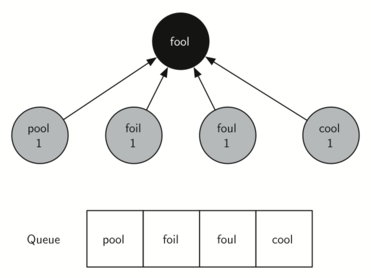




책에서는 추가 설명과 코드가 있었지만, 우선 그림 먼저 가져왔습니다. 

그림에서 볼 수 있듯, 시작점이 되는 단어는 fool입니다. 우리는 여기서 이 fool과의 거리가 1인 네 단어를 찾을 수 있습니다. 우리는 이 단어들을 순서대로 큐에 넣습니다. 여기서 주목해야 할 점은, 우선 시작점인 fool은 당연히 탐험된 상태이기 때문에 검은색으로, 나머지 네 점은 발견된 상태이기에(큐에 넣어진 상태이기에) 회색 점으로 표현됩니다. 그림에 나타나지 않은 점들은 아직 흰색점인 상태이겠구요.



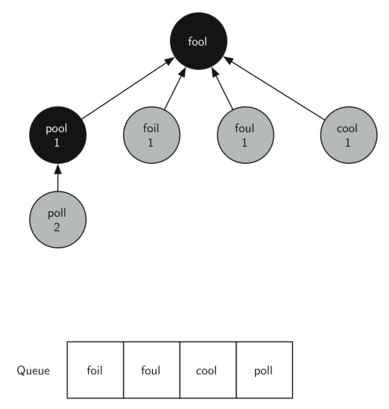




이제 fool의 역할이 끝났군요. 

다음 그림은 큐에서 pool을 빼고 이 pool을 현재 점(?)으로 설정한 뒤에, 이를 토대로 pool에서 거리가 1인 점을 찾아 큐에 넣는 것입니다. 여기서는 poll이 되겠네요. 이때 pool은 탐험이 되었으니 검은색으로 표시되고, poll은 발견이 되었으니 회색으로 표시가 됩니다.



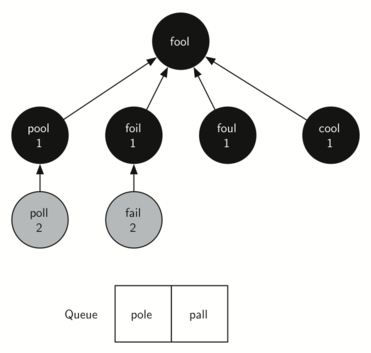




bfs는 거리가 k+1인 점을 탐색하기 전에, k인 점을 모두 탐색하는 알고리즘이라고 말씀 드렸었죠. 그렇기에 다음 점은 poll이 아닌 foil, foul, cool입니다. 여기서 발견된 점은 foil에 붙어있는 fail뿐이군요. 이제 SS에서 거리가 2인 점을 모두 발견하고, 거리가 1인 점을 모두 탐험했습니다.




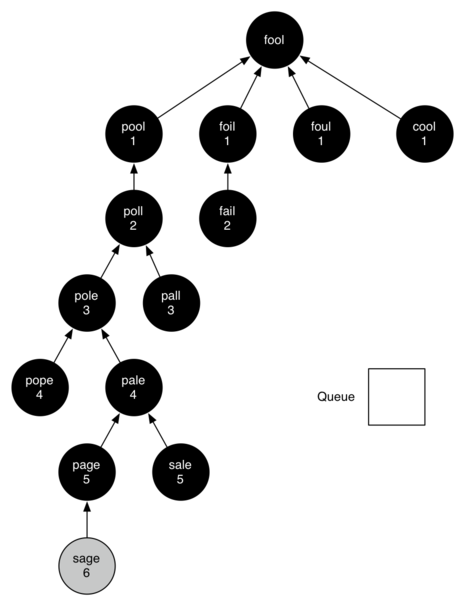



그렇다면 이제는 거리가 2인 점의 처음(큐의 제일 앞)부터 다시 위와 같은 방식으로 발견과 탐험을 진행할 수 있겠죠. 위의 그림이 바로 탐험을 모두 끝낸 그림입니다. bfs를 통해, 우리는 fool에서 탐색을 시작하여 그래프가 끝나는, 거리가 가장 짧은 단어가 sage라는 것을 알 수 있게 되었습니다!






In [2]:
from pythonds.graphs import Graph, Vertex
from pythonds.basic import Queue

def bfs(g,start):
  start.setDistance(0)
  start.setPred(None)
  vertQueue = Queue()
  vertQueue.enqueue(start)
  while (vertQueue.size() > 0):
    currentVert = vertQueue.dequeue()
    for nbr in currentVert.getConnections():
      if (nbr.getColor() == 'white'):
        nbr.setColor('gray')
        nbr.setDistance(currentVert.getDistance() + 1)
        nbr.setPred(currentVert)
        vertQueue.enqueue(nbr)
    currentVert.setColor('black')

위의 코드가 바로 우리가 그림으로 이야기했던 bfs를 시행하기 위한 코드입니다.
 
이를 구현하기 위해 정점에 색상 관련 기능이 추가되어야만 한다고 설명했지만, 어쨌든 위와 같은 코드를 시행하기 위해선 큐를 써야한다든가 등의 추가사항이 있겠습니다.

In [ ]:
def traverse(y):
    x = y
    while (x.getPred()):
        print(x.getId())
        x = x.getPred()
    print(x.getId())

traverse(g.getVertex('sage'))

마지막으로, 위의 코드는 예컨대 sage라는 단어를 출력하기 위해 커쳤던 word ladder을 역으로 탐색하는 과정을 보여준다고 할 수 있습니다. 

참고로 그래프를 잘 만들었을 때, BFS의 시간복잡도는 O(V+E)라고 할 수 있겠네요. 정점과 선을 한 번씩 거치게 되니까요.